# **Heart Arrythmia Classification**
> **Name:** Srinivas Natarajan <br>
> **Email:** nsrinivas06@gmail.com <br>
> **Ph.no:** 9940023607 <br>

<br>

### The 4th markdown is the final pipeline for the project



---

<br>

## **1. Loading Data/Packages**

In [1]:
#Importing data from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
DATA_PATH = "/content/drive/My Drive/Internship Files/Velozity/"

In [3]:
!pip install wfdb &> /dev/null
!pip install pyedflib
!pip install tqdm
!pip install biosppy
!pip install matplotlib==3.1.3

     |████████████████████████████████| 2.4 MB 4.5 MB/s 
     |████████████████████████████████| 1.5 MB 5.4 MB/s 
  Created wheel for biosppy: filename=biosppy-0.8.0-py2.py3-none-any.whl size=100176 sha256=c20727223d485d7b787e0a3a3003e9f5fabc4f01cb850683db2f3ed82011cd3e
  Stored in directory: /root/.cache/pip/wheels/32/17/9d/77adbf0db713546eaa1c7a1480b2dce91fa724a133115dc20c
Successfully built biosppy
     |████████████████████████████████| 13.1 MB 4.4 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
wfdb 3.4.1 requires matplotlib>=3.3.4, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math
import os
import warnings
warnings.filterwarnings('ignore')

import wfdb as wf
import pyedflib

from scipy import signal
from biosppy.signals import ecg

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample, class_weight
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
import keras
from keras import backend as K
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Input, Activation, Add, Softmax
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.utils.np_utils import to_categorical

---

<br>

## **2. Multi Class Test CNN**

### I processed the MITDB Dataset using the methodology given in the paper below. 

> Kachuee, M., Fazeli, S., & Sarrafzadeh, M. (2018). ECG Heartbeat Classification: A Deep Transferable Representation. 2018 IEEE International Conference on Healthcare Informatics (ICHI). https://doi.org/10.1109/ichi.2018.00092 (https://arxiv.org/pdf/1805.00794.pdf)

### The process followed is:

1. Splitting the continuous ECG signal to 10s windows and select a 10s window from an ECG signal. <br>
2. Normalizing the amplitude values to the range of between zero and one. <br>
3. Finding the set of all local maximums based on zerocrossings of the first derivative. <br>
4. Finding the set of ECG R-peak candidates by applying a threshold of 0.9 on the normalized value of the local maximums. <br>
5. Finding the median of R-R time intervals as the nominal heartbeat period of that window (T). <br>
6. For each R-peak, selecting a signal part with the length equal to 1.2T. <br>
7. Padding each selected part with zeros to make its length equal to a predefined fixed length. <br>

### **A. Exploratory Data Analysis**

<br>

#### The dataset divided the ECG into **10 second** segments with **187 features** to represent the meaning they convey

In [6]:
train_df = pd.read_csv(DATA_PATH + 'mitbih_train.csv',header=None)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,0.044118,0.061275,0.066176,0.061275,0.049020,0.073529,0.061275,0.061275,0.066176,0.068627,0.095588,0.075980,0.093137,0.105392,0.115196,0.102941,0.117647,0.125000,0.142157,0.127451,0.151961,0.144608,0.164216,0.144608,0.159314,0.151961,0.154412,0.142157,0.151961,0.151961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,0.074074,0.062678,0.065527,0.065527,0.062678,0.076923,0.071225,0.082621,0.091168,0.096866,0.082621,0.082621,0.091168,0.105413,0.122507,0.148148,0.182336,0.193732,0.213675,0.207977,0.222222,0.253561,0.270655,0.287749,0.284900,0.293447,0.256410,0.247863,0.188034,0.145299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,0.056757,0.043243,0.067568,0.062162,0.078378,0.072973,0.086486,0.081081,0.108108,0.110811,0.135135,0.135135,0.170270,0.183784,0.216216,0.237838,0.270270,0.286486,0.316216,0.318919,0.332432,0.297297,0.267568,0.216216,0.189189,0.132432,0.118919,0.064865,0.064865,0.043243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,0.063536,0.082873,0.085635,0.093923,0.113260,0.124309,0.140884,0.132597,0.140884,0.091160,0.085635,0.074586,0.071823,0.080110,0.096685,0.118785,0.138122,0.140884,0.138122,0.146409,0.110497,0.102210,0.060773,0.027624,0.038674,0.013812,0.011050,0.013812,0.033149,0.005525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,0.131455,0.122066,0.140845,0.159624,0.150235,0.145540,0.136150,0.169014,0.178404,0.173709,0.183099,0.201878,0.187793,0.164319,0.187793,0.215962,0.215962,0.201878,0.211268,0.230047,0.215962,0.230047,0.239437,0.267606,0.253521,0.230047,0.220657,0.225352,0.211268,0.173709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
test_df = pd.read_csv(DATA_PATH + 'mitbih_test.csv',header=None)
test_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,0.030992,0.028926,0.035124,0.026860,0.039256,0.035124,0.043388,0.047521,0.053719,0.053719,0.070248,0.072314,0.084711,0.097107,0.121901,0.132231,0.169421,0.196281,0.214876,0.235537,0.254132,0.264463,0.285124,0.272727,0.266529,0.239669,0.214876,0.173554,0.157025,0.123967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,0.304029,0.336996,0.377289,0.391941,0.439560,0.446886,0.457875,0.479853,0.512821,0.534799,0.586081,0.586081,0.604396,0.633700,0.615385,0.582418,0.564103,0.520147,0.490842,0.490842,0.468864,0.454212,0.450549,0.465201,0.450549,0.432234,0.424908,0.410256,0.391941,0.369963,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,0.106195,0.141593,0.128319,0.150442,0.132743,0.150442,0.132743,0.150442,0.123894,0.163717,0.137168,0.141593,0.132743,0.150442,0.128319,0.146018,0.119469,0.123894,0.101770,0.092920,0.070796,0.079646,0.066372,0.070796,0.079646,0.092920,0.088496,0.084071,0.079646,0.088496,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,0.102083,0.122917,0.150000,0.168750,0.172917,0.170833,0.168750,0.164583,0.156250,0.152083,0.147917,0.147917,0.145833,0.145833,0.141667,0.141667,0.147917,0.158333,0.168750,0.179167,0.191667,0.206250,0.220833,0.239583,0.258333,0.275000,0.287500,0.308333,0.320833,0.331250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,0.080537,0.104027,0.093960,0.117450,0.097315,0.134228,0.124161,0.161074,0.171141,0.194631,0.204698,0.261745,0.275168,0.332215,0.345638,0.395973,0.406040,0.456376,0.446309,0.446309,0.399329,0.369128,0.308725,0.295302,0.265101,0.271812,0.258389,0.268456,0.261745,0.281879,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
def plot_class_balance(train_df, title):
  """
    Input: 
      train_df - Dataset in CSV form
      title - Title of the plot you want
      
    Output: 
      Barplot of the distribution of records in each class
  """
  train_df[187] = train_df[187].astype(int)
  class_count = train_df[187].value_counts()
  colors = {"Normal":'red', "Paced":'green', "Premature ventricular contraction":"blue", "Atrial premature":"skyblue", "Fusion of ventricular and normal": "orange"} 
  labels = ["Normal", "Paced", "Premature ventricular contraction", "Atrial premature", "Fusion of ventricular and normal"]

  sns.set_palette(sns.color_palette(colors.values()))

  fig, ax = plt.subplots(figsize=(14,8))
  sns.barplot(y = class_count, x=['N (0)','Q (4)','V (2)','S (1)','F (3)'])

  for p in ax.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h / 2)
    text = f'{h:0.2f}'
    ax.annotate(s=h, xy=xy, ha='center', weight='bold')

  handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
  plt.legend(handles, labels)
  plt.xlabel("Classes", fontsize=12)
  plt.ylabel("Number of examples in each class", fontsize=12)
  plt.title(title, fontsize=14)

<br>

#### As we can see below, the dataset is highly unbalanced. Proceeding without resampling the data will result in an inferior performing model.

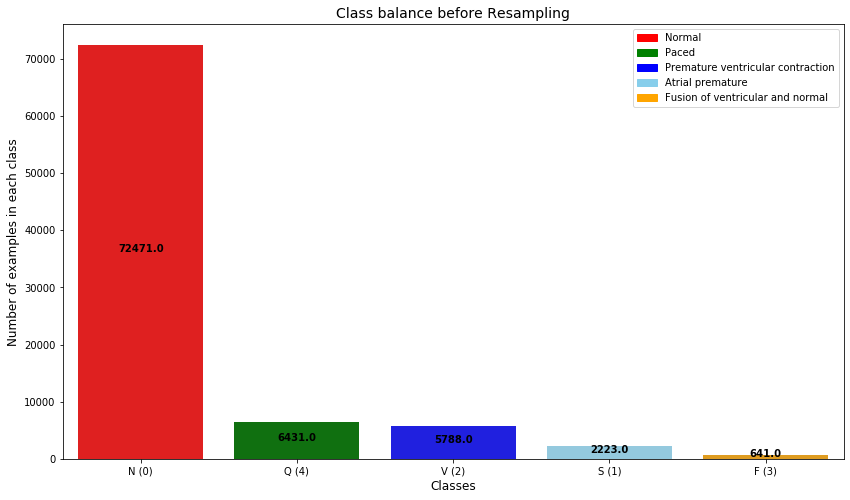

In [9]:
plot_class_balance(train_df, "Class balance before Resampling")

In [10]:
df_1 = train_df[train_df[187]==1]
df_2 = train_df[train_df[187]==2]
df_3 = train_df[train_df[187]==3]
df_4 = train_df[train_df[187]==4]
df_0 = (train_df[train_df[187]==0]).sample(n=20000,random_state=42) # We reduce the sample from 72,471 to just 20,000 randomly selected points

df_1_upsample = resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample = resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample = resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample = resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df = pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

<br> 

#### Balanced the classes by resampling data points  

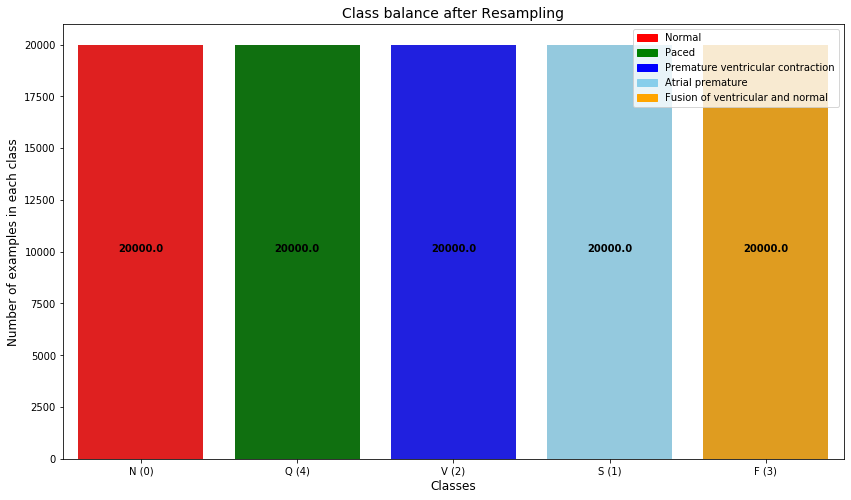

In [11]:
plot_class_balance(train_df, "Class balance after Resampling")

In [12]:
# Selecting a single point from each class for visualization
c = train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))
c.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
34458,0.950192,1.000000,0.666667,0.291188,0.000000,0.095785,0.226054,0.279693,0.287356,0.310345,0.295019,0.302682,0.283525,0.295019,0.298851,0.287356,0.306513,0.272031,0.275862,0.295019,0.291188,0.275862,0.283525,0.283525,0.310345,0.283525,0.295019,0.306513,0.329502,0.329502,0.337165,0.383142,0.413793,0.440613,0.444444,0.471264,0.471264,0.478927,0.478927,0.494253,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
74381,0.838202,0.791011,0.271910,0.000000,0.128090,0.186517,0.173034,0.170787,0.168539,0.150562,0.184270,0.206742,0.204494,0.208989,0.226966,0.240449,0.267416,0.258427,0.265169,0.253933,0.258427,0.267416,0.301124,0.276405,0.301124,0.310112,0.323595,0.307865,0.280899,0.249438,0.224719,0.242697,0.215730,0.204494,0.195506,0.211236,0.231461,0.200000,0.244944,0.204494,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
75191,0.000000,0.029268,0.081301,0.138211,0.235772,0.351220,0.413008,0.489431,0.549594,0.601626,0.640650,0.699187,0.764228,0.803252,0.824390,0.845528,0.850407,0.868293,0.892683,0.908943,0.921951,0.934959,0.952846,0.970732,0.973984,0.985366,0.988618,1.000000,0.998374,0.993496,0.983740,0.978862,0.949593,0.931707,0.900813,0.881301,0.847154,0.830894,0.801626,0.780488,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
81012,1.000000,0.848656,0.530410,0.213579,0.077793,0.124470,0.124470,0.096181,0.090523,0.084866,0.065064,0.063649,0.065064,0.055163,0.057992,0.063649,0.077793,0.099010,0.101839,0.128713,0.166902,0.192362,0.223479,0.254597,0.287129,0.329562,0.356436,0.380481,0.417256,0.422914,0.424328,0.422914,0.417256,0.410184,0.386139,0.374823,0.356436,0.332390,0.309760,0.284300,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
84136,0.667692,0.590769,0.556923,0.526154,0.501538,0.470769,0.430769,0.372308,0.304615,0.184615,0.129231,0.086154,0.083077,0.089231,0.104615,0.160000,0.258462,0.326154,0.387692,0.409231,0.436923,0.446154,0.476923,0.464615,0.470769,0.480000,0.504615,0.507692,0.532308,0.535385,0.541538,0.544615,0.556923,0.553846,0.547692,0.560000,0.560000,0.560000,0.575385,0.581538,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


Text(0.5, 1.0, 'Paced')

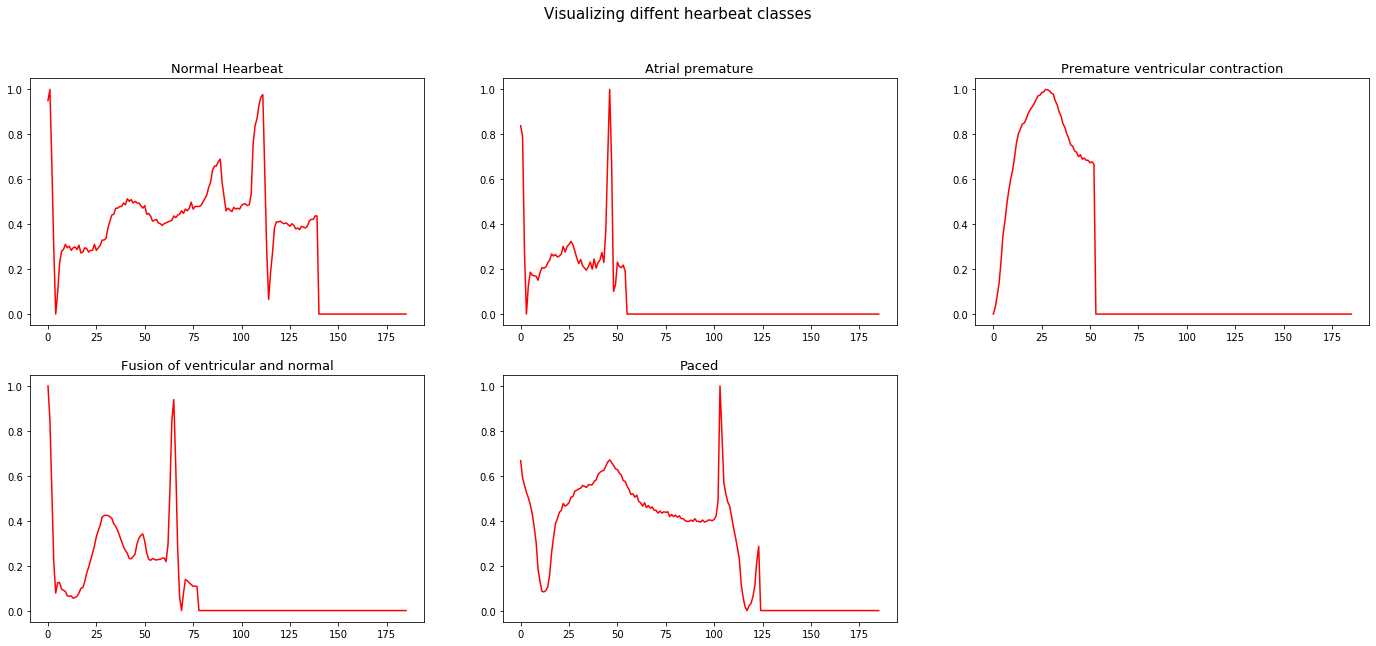

In [13]:
plt.figure(figsize=(24,10))
plt.suptitle("Visualizing diffent hearbeat classes", fontsize=15)

ax1 = plt.subplot2grid((2, 3), (0, 0))
ax2 = plt.subplot2grid((2, 3), (0, 1))
ax3 = plt.subplot2grid((2, 3), (0, 2))
ax4 = plt.subplot2grid((2, 3), (1, 0))
ax5 = plt.subplot2grid((2, 3), (1, 1))


ax1.plot(c.iloc[0,:186])
ax1.set_title("Normal Hearbeat", fontsize=13)
ax2.plot(c.iloc[1,:186])
ax2.set_title("Atrial premature", fontsize=13)
ax3.plot(c.iloc[2,:186])
ax3.set_title("Premature ventricular contraction", fontsize=13)
ax4.plot(c.iloc[3,:186])
ax4.set_title("Fusion of ventricular and normal", fontsize=13)
ax5.plot(c.iloc[4,:186])
ax5.set_title("Paced", fontsize=13)


#### Histogram Plots

In [ ]:
def plot_hist(class_number,size,min_,bins):
    img = train_df.loc[train_df[187]==class_number].values
    img = img[:,min_:size]
    img_flatten = img.flatten()

    final1 = np.arange(min_,size)
    for i in range (img.shape[0]-1):
        tempo1 = np.arange(min_,size)
        final1 = np.concatenate((final1, tempo1), axis=None)
    print(len(final1))
    print(len(img_flatten))
    plt.hist2d(final1,img_flatten, bins=(bins,bins),cmap=plt.cm.jet)
    plt.show()

1300000
1300000


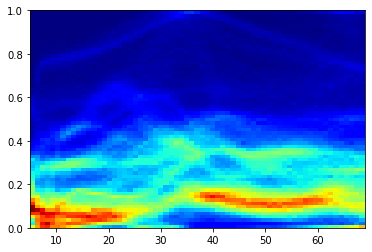

In [ ]:
plot_hist(0,70,5,65)

900000
900000


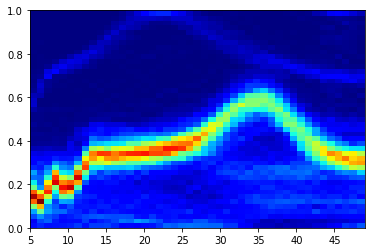

In [ ]:
plot_hist(1,50,5,45)

900000
900000


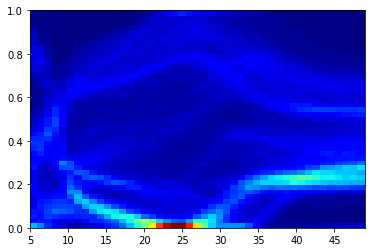

In [ ]:
plot_hist(2,50,5,45)


### **B. Model 2 (CNN from Paper)**

In [15]:
def add_gaussian_noise(signal):
  """
    Input: 
      signal - Numpy array which contains the ECG signal
    Output: 
      Numpy array which contains the noise added signal
  """
  noise = np.random.normal(0,0.5,186)
  return (signal+noise)

In [16]:
# Making the target variable categorical
target_train = train_df[187]
y_train = to_categorical(target_train)

target_test = test_df[187]
y_test = to_categorical(target_test)

In [17]:
X_train = train_df.iloc[:,:186].values
X_test = test_df.iloc[:,:186].values

print(X_train.shape, " ", X_test.shape)

# Adding gausian Noise to the signal
for i in range(len(X_train)):
    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])

X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

print(X_train.shape, " ", X_test.shape)

(100000, 186)   (21892, 186)
(100000, 186, 1)   (21892, 186, 1)


In [18]:
print(y_train.shape, " ", y_test.shape)

(100000, 5)   (21892, 5)


In [19]:
n_obs, feature, depth = X_train.shape
batch_size = 500

In [24]:
K.clear_session()

inp = Input(shape=(feature, depth))
C = Conv1D(filters=32, kernel_size=5, strides=1)(inp)

C11 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C)
A11 = Activation("relu")(C11)
C12 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A11)
S11 = Add()([C12, C])
A12 = Activation("relu")(S11)
M11 = MaxPooling1D(pool_size=5, strides=2)(A12)


C21 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M11)
A21 = Activation("relu")(C21)
C22 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A21)
S21 = Add()([C22, M11])
A22 = Activation("relu")(S11)
M21 = MaxPooling1D(pool_size=5, strides=2)(A22)


C31 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M21)
A31 = Activation("relu")(C31)
C32 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A31)
S31 = Add()([C32, M21])
A32 = Activation("relu")(S31)
M31 = MaxPooling1D(pool_size=5, strides=2)(A32)


C41 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M31)
A41 = Activation("relu")(C41)
C42 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A41)
S41 = Add()([C42, M31])
A42 = Activation("relu")(S41)
M41 = MaxPooling1D(pool_size=5, strides=2)(A42)


C51 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M41)
A51 = Activation("relu")(C51)
C52 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A51)
S51 = Add()([C52, M41])
A52 = Activation("relu")(S51)
M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

F1 = Flatten()(M51)

D1 = Dense(32)(F1)
A6 = Activation("relu")(D1)
D2 = Dense(32)(A6)
D3 = Dense(5)(D2)
A7 = Softmax()(D3)

model = Model(inputs=inp, outputs=A7)

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 186, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 182, 32)      192         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 182, 32)      5152        ['conv1d[0][0]']                 
                                                                                                  
 activation (Activation)        (None, 182, 32)      0           ['conv1d_1[0][0]']               
                                                                                              

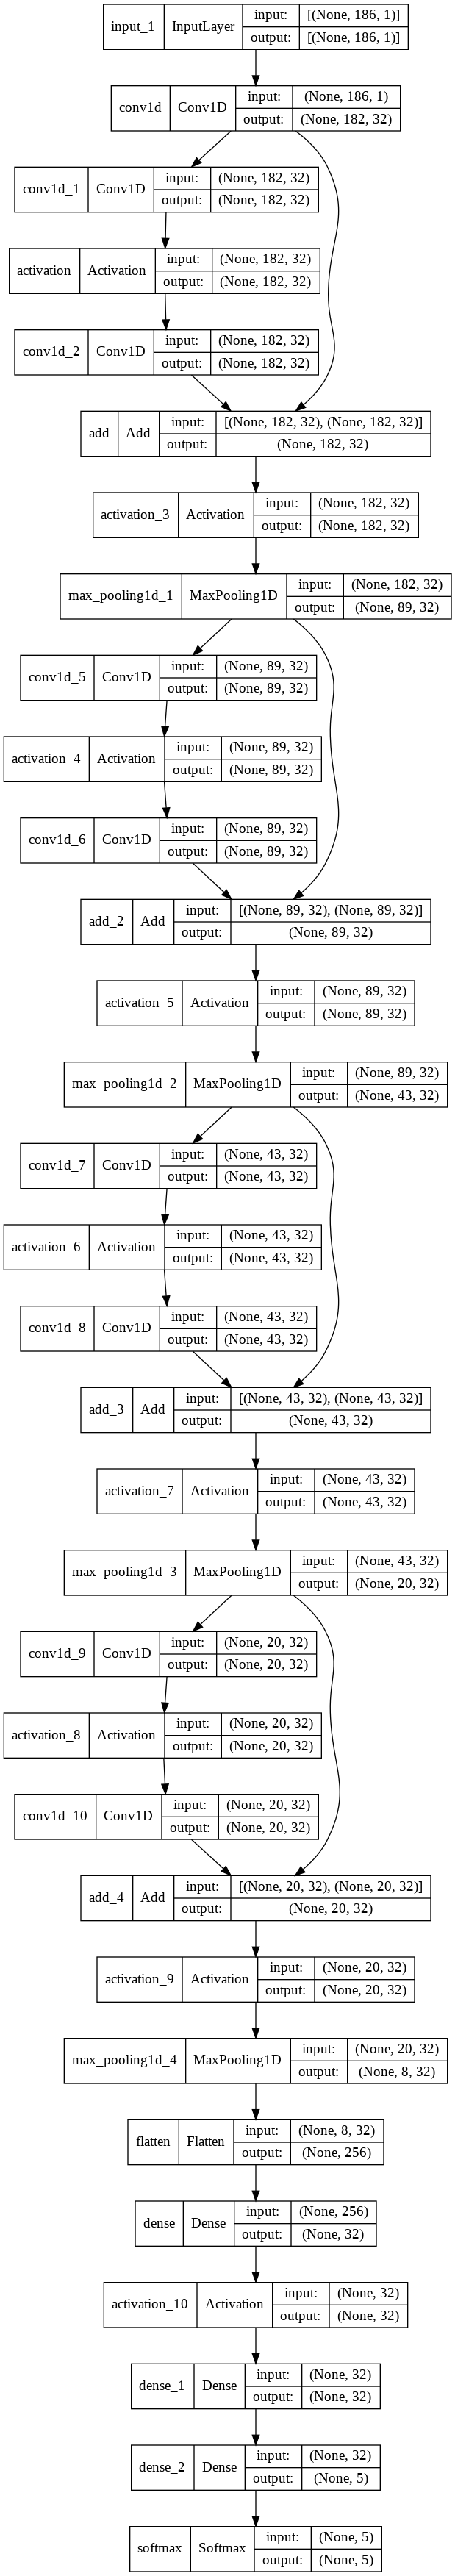

In [26]:
plot_model(model, to_file=DATA_PATH + 'model_plot.png', show_shapes=True, show_layer_names=True)

In [27]:
def exp_decay(epoch):
  """
    Input: 
      epoch - Epoch number
    Output: 
      New Learning rate
  """
  initial_lrate = 0.001
  k = 0.75
  t = n_obs//(10000 * batch_size)  # every epoch we do n_obs/batch_size iteration
  lrate = initial_lrate * math.exp(-k*t)
  return lrate

lrate = LearningRateScheduler(exp_decay)

In [28]:
adam = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)

In [29]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)

In [30]:
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [31]:
history = model.fit(X_train, y_train, 
                    epochs=30, 
                    batch_size=batch_size, 
                    validation_data=(X_test, y_test), 
                    callbacks=[lrate, callback])

Epoch 1/30
200/200 [==============================] - 94s 462ms/step - loss: 1.0790 - accuracy: 0.5694 - val_loss: 1.0780 - val_accuracy: 0.5111 - lr: 0.0010
Epoch 2/30
200/200 [==============================] - 94s 471ms/step - loss: 0.8901 - accuracy: 0.6555 - val_loss: 0.9374 - val_accuracy: 0.6340 - lr: 0.0010
Epoch 3/30
200/200 [==============================] - 94s 470ms/step - loss: 0.8466 - accuracy: 0.6761 - val_loss: 0.8721 - val_accuracy: 0.6647 - lr: 0.0010
Epoch 4/30
200/200 [==============================] - 92s 460ms/step - loss: 0.8153 - accuracy: 0.6888 - val_loss: 0.8667 - val_accuracy: 0.6649 - lr: 0.0010
Epoch 5/30
200/200 [==============================] - 92s 459ms/step - loss: 0.7974 - accuracy: 0.6960 - val_loss: 0.8982 - val_accuracy: 0.6677 - lr: 0.0010
Epoch 6/30
200/200 [==============================] - 92s 459ms/step - loss: 0.7813 - accuracy: 0.7033 - val_loss: 0.8779 - val_accuracy: 0.6552 - lr: 0.0010
Epoch 7/30
200/200 [==============================] 

In [32]:
model.save(DATA_PATH + 'my_model_30')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Internship Files/Velozity/my_model_30/assets


In [59]:
model.save(DATA_PATH + 'my_model')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Internship Files/Velozity/my_model/assets


In [60]:
y_pred = model.predict(X_test, batch_size=1000)

In [33]:
def evaluate_model(history,X_test,y_test,model):
  """
    Input: 
      history - Model history variable
      X_test - Test features
      y_test - Target test variables
      model - Keras Model 

    Output:
      Accuracy Plot (Training + Validation)
      Loss Plot (Training + Validation)
      Confusion matrix
      Accuracy
      Classification Report 
  """  
  scores = model.evaluate((X_test),y_test, verbose=0)
  
  fig, axs = plt.subplots(1,3, figsize=(18,5))
  fig.tight_layout()

  axs[0].plot(history.history['accuracy'])
  axs[0].plot(history.history['val_accuracy'])
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('Accuracy')
  axs[0].set_title('Model - Accuracy')
  axs[0].legend(['Training', 'Validation'], loc='lower right')

  axs[1].plot(history.history['loss'])
  axs[1].plot(history.history['val_loss'])
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Model Loss')
  axs[1].set_title('Model - Loss')
  axs[1].legend(['Training', 'Validation'], loc='upper right')

  target_names=['N','S','V','F','Q']
  
  y_true=[]
  for element in y_test:
      y_true.append(np.argmax(element))
  prediction_proba = model.predict(X_test)
  prediction = np.argmax(prediction_proba,axis=1)
  cnf_matrix = confusion_matrix(y_true, prediction)    
  g = sns.heatmap(cnf_matrix, annot=True, cmap='Blues', fmt='g', ax=axs[2],
                  xticklabels=target_names, yticklabels=target_names)
  plt.show()

  print("\nAccuracy: %.2f%% \n" % (scores[1]*100))
  print(classification_report(y_true, prediction, target_names=target_names))
    

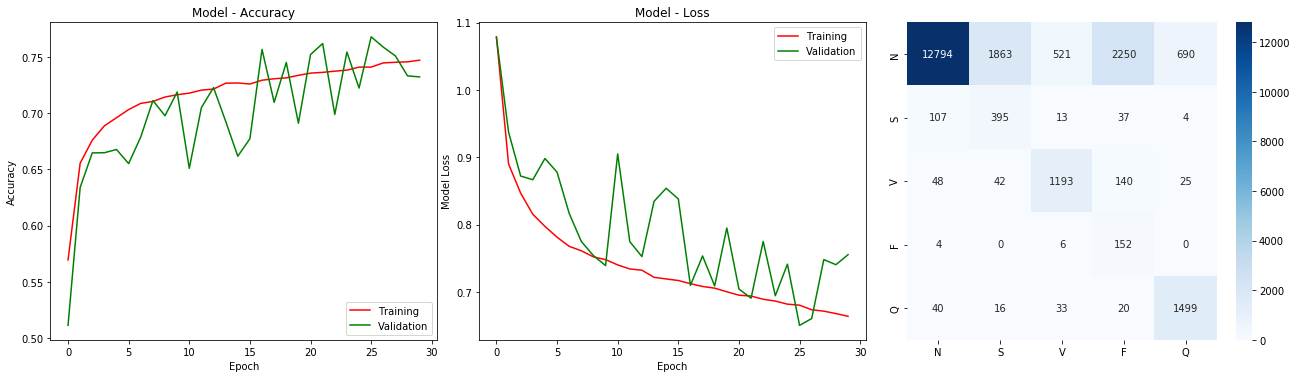


Accuracy: 73.24% 

              precision    recall  f1-score   support

           N       0.98      0.71      0.82     18118
           S       0.17      0.71      0.28       556
           V       0.68      0.82      0.74      1448
           F       0.06      0.94      0.11       162
           Q       0.68      0.93      0.78      1608

    accuracy                           0.73     21892
   macro avg       0.51      0.82      0.55     21892
weighted avg       0.91      0.73      0.80     21892



In [34]:
evaluate_model(history, X_test, y_test, model)

---

<br>

## **3. EDF Processing Test**

### Using the "pyedflib" package to read EDF files. We get a pyedflib.EdfReader object which we parse to get a numpy array

In [ ]:
#Open file reader for the .edf file
f = pyedflib.EdfReader(DATA_PATH + "SampleECG.edf")

In [ ]:
n = f.signals_in_file #Number of signals in the file
signal_labels = f.getSignalLabels() 
sigbufs = np.zeros((n, f.getNSamples()[0]))
for i in np.arange(n):
    sigbufs[i, :] = f.readSignal(i)   # Numpy array of the signal values

In [ ]:
print(sigbufs)
print(sigbufs.shape)
print(signal_labels)

[[-5.51805170e-03 -6.14612262e-03 -6.86391797e-03 ... -4.48622089e-05
  -4.48622089e-05 -4.48622089e-05]]
(1, 400000)
['ECG']


### Plot of the entire ECG   

In [ ]:
plt.figure(figsize=(30,8))
#fig = plt.figure()
ax = plt.axes()
for i in np.arange(n):
  ax.plot(f.readSignal(i))
plt.show()

In [ ]:
print(f.readSignal(0).shape)
print(type(f.readSignal(0)))
print(f.getSampleFrequency(0))

(400000,)
<class 'numpy.ndarray'>
1000.0


In [ ]:
data = sigbufs
print(data,"\n", data.shape)

[[-5.51805170e-03 -6.14612262e-03 -6.86391797e-03 ... -4.48622089e-05
  -4.48622089e-05 -4.48622089e-05]] 
 (1, 400000)


<br> 

### Identifying Rpeaks and splitting the ECG accordingly. These segments are then processed according to the paper.

In [ ]:
for channelid, channel in enumerate(data):

        out = ecg.ecg(signal=channel, sampling_rate=360, show=False)
        rpeaks = np.zeros_like(channel, dtype='float')
        rpeaks[out['rpeaks']] = 1.0

        print("Rpeaks: ", rpeaks)

        beatstoremove = np.array([0])
        beats = np.split(channel, out['rpeaks'])

        for idx, idxval in enumerate(out['rpeaks']):
            firstround = idx == 0
            lastround = idx == len(beats) - 1

            # Skip first and last beat.
            if (firstround or lastround):
                continue

            # Get the classification value that is on
            # or near the position of the rpeak index.
            fromidx = 0 if idxval < 10 else idxval - 10
            toidx = idxval + 10

            # Append some extra readings from next beat.
            beats[idx] = np.append(beats[idx], beats[idx+1][:40])

            # Normalize the readings to a 0-1 range for ML purposes.
            beats[idx] = (beats[idx] - beats[idx].min()) / beats[idx].ptp()

            # Resample from 360Hz to 125Hz
            newsize = int((beats[idx].size * 125 / 360) + 0.5)
            beats[idx] = signal.resample(beats[idx], newsize)

            # Skipping records that are too long.
            if (beats[idx].size > 187):
                beatstoremove = np.append(beatstoremove, idx)
                continue

            # Pad with zeroes.
            zerocount = 187 - beats[idx].size
            beats[idx] = np.pad(beats[idx], (0, zerocount), 'constant', constant_values=(0.0, 0.0))

            # Append the classification to the beat data.
            beats[idx] = np.append(beats[idx], 0)

Rpeaks:  [0. 0. 0. ... 0. 0. 0.]


In [ ]:
print(len(beats), type(beats))
for i in range(10):
  print(len(beats[i]), end=" ")

In [ ]:
print(len(beatstoremove), type(beatstoremove))
print(beatstoremove.shape)
print(beatstoremove)

In [ ]:
beatstoremove = np.append(beatstoremove, len(beats)-1) #Removing unnecessary beats

# Remove first and last beats and the ones without classification.
beats = np.delete(beats, beatstoremove)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
savedata = np.array(list(beats[:]), dtype=np.float)
outfn = DATA_PATH + 'SampleECG' +'.csv'
print('Generating ', outfn)
with open(outfn, "wb") as fin:
    np.savetxt(fin, savedata, delimiter=",", fmt='%f')

<br>

### Processed the data into 187 features which can be passeed to the model

In [ ]:
import pandas as pd

temp_df = pd.read_csv(DATA_PATH + 'SampleECG.csv', header=None)
temp_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.752733,0.730747,0.159375,0.319714,0.266970,0.307124,0.270779,0.285674,0.281439,0.283470,0.266059,0.277535,0.280732,0.282037,0.273571,0.272187,0.267126,0.282263,0.262759,0.272487,0.264431,0.258931,0.249464,0.261821,0.254205,0.262991,0.234557,0.256163,0.211733,0.225056,0.197015,0.194620,0.162682,0.170036,0.142870,0.155596,0.133188,0.154629,0.165393,0.205240,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.628595,0.571475,-0.009939,0.076968,0.122889,0.170717,0.142956,0.171063,0.157647,0.162291,0.163033,0.165251,0.156195,0.173852,0.162099,0.174743,0.167370,0.172260,0.162814,0.178717,0.160566,0.170482,0.157549,0.166379,0.149927,0.163861,0.129142,0.147496,0.112918,0.119430,0.083183,0.095984,0.054228,0.077860,0.043040,0.059578,0.050576,0.093480,0.097575,0.162378,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.735441,0.738430,0.084738,0.206169,0.121107,0.179561,0.122728,0.175328,0.116942,0.162638,0.113821,0.158204,0.110882,0.164529,0.117946,0.159603,0.125687,0.151115,0.119840,0.146836,0.117802,0.139753,0.106823,0.125403,0.105927,0.107156,0.082527,0.071278,0.051213,0.047551,0.031255,0.016727,0.018052,0.006963,0.016562,0.029653,0.068658,0.104682,0.144912,0.166005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.738411,0.699388,0.051565,0.203068,0.125145,0.175656,0.134468,0.155478,0.135086,0.151918,0.130952,0.147953,0.130422,0.151835,0.135284,0.153212,0.132960,0.152491,0.123780,0.144768,0.132993,0.149689,0.125274,0.142997,0.113791,0.118125,0.093140,0.094810,0.063433,0.068685,0.016822,0.045053,0.006327,0.042213,0.026445,0.088469,0.094124,0.154359,0.149767,0.192996,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.680462,0.680163,-0.019243,0.161988,0.107638,0.159469,0.108530,0.181673,0.105343,0.170670,0.122808,0.162025,0.126172,0.160585,0.134910,0.170461,0.153536,0.153279,0.133147,0.134548,0.133930,0.149337,0.123503,0.132191,0.136110,0.124082,0.117762,0.088232,0.077982,0.050404,0.034911,0.029181,0.011273,0.007717,0.019675,0.035083,0.044768,0.059371,0.083085,0.134263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## **4. Predicting using the model**

### Steps:

> 1. Load proceesed data as a CSV file using pandas
2. Load model from the save folder
3. Reshape input
4. Predict class probabilities and output a list of predicted classes 

In [9]:
# 1. Loading the saved CSV file that was processed

df = pd.read_csv(DATA_PATH + 'V5.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.752733,0.730747,0.159375,0.319714,0.266970,0.307124,0.270779,0.285674,0.281439,0.283470,0.266059,0.277535,0.280732,0.282037,0.273571,0.272187,0.267126,0.282263,0.262759,0.272487,0.264431,0.258931,0.249464,0.261821,0.254205,0.262991,0.234557,0.256163,0.211733,0.225056,0.197015,0.194620,0.162682,0.170036,0.142870,0.155596,0.133188,0.154629,0.165393,0.205240,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.628595,0.571475,-0.009939,0.076968,0.122889,0.170717,0.142956,0.171063,0.157647,0.162291,0.163033,0.165251,0.156195,0.173852,0.162099,0.174743,0.167370,0.172260,0.162814,0.178717,0.160566,0.170482,0.157549,0.166379,0.149927,0.163861,0.129142,0.147496,0.112918,0.119430,0.083183,0.095984,0.054228,0.077860,0.043040,0.059578,0.050576,0.093480,0.097575,0.162378,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.735441,0.738430,0.084738,0.206169,0.121107,0.179561,0.122728,0.175328,0.116942,0.162638,0.113821,0.158204,0.110882,0.164529,0.117946,0.159603,0.125687,0.151115,0.119840,0.146836,0.117802,0.139753,0.106823,0.125403,0.105927,0.107156,0.082527,0.071278,0.051213,0.047551,0.031255,0.016727,0.018052,0.006963,0.016562,0.029653,0.068658,0.104682,0.144912,0.166005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.738411,0.699388,0.051565,0.203068,0.125145,0.175656,0.134468,0.155478,0.135086,0.151918,0.130952,0.147953,0.130422,0.151835,0.135284,0.153212,0.132960,0.152491,0.123780,0.144768,0.132993,0.149689,0.125274,0.142997,0.113791,0.118125,0.093140,0.094810,0.063433,0.068685,0.016822,0.045053,0.006327,0.042213,0.026445,0.088469,0.094124,0.154359,0.149767,0.192996,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.680462,0.680163,-0.019243,0.161988,0.107638,0.159469,0.108530,0.181673,0.105343,0.170670,0.122808,0.162025,0.126172,0.160585,0.134910,0.170461,0.153536,0.153279,0.133147,0.134548,0.133930,0.149337,0.123503,0.132191,0.136110,0.124082,0.117762,0.088232,0.077982,0.050404,0.034911,0.029181,0.011273,0.007717,0.019675,0.035083,0.044768,0.059371,0.083085,0.134263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# 2. Loading model that we saved
loaded_model = tf.keras.models.load_model(DATA_PATH + 'my_model_30')

In [12]:
# 3. Reshape data
X = df.iloc[:,:186].values
X = X.reshape(len(X), X.shape[1],1)
print(X.shape)

(2266, 186, 1)


In [15]:
# 4. Output predicted class list
y_pred = loaded_model.predict(X, batch_size=1000)
prediction = np.argmax(y_pred,axis=1)

In [16]:
print(prediction, type(prediction))

[4 4 0 ... 0 0 0] <class 'numpy.ndarray'>


In [ ]:
# Save the classes
np.save('ECG_classification', prediction)

---

<br>

## **Testing preprocessing**

In [ ]:
!pip install tqdm
!pip install wfdb
!pip install biosppy
!pip install datasets

In [ ]:
import os
import wfdb as wf
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from biosppy.signals import ecg

In [ ]:
record = wf.rdsamp(DATA_PATH + "mit-bih-arrhythmia-database-1.0.0/100")
annotation = wf.rdann(DATA_PATH + "mit-bih-arrhythmia-database-1.0.0/100", 'atr')

In [ ]:
print(record)

(array([[-0.145, -0.065],
       [-0.145, -0.065],
       [-0.145, -0.065],
       ...,
       [-0.675, -0.365],
       [-0.765, -0.335],
       [-1.28 ,  0.   ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V5'], 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal']})


In [ ]:
print('Total files: ', len(record))
print("0: \n", record[0], "  ", record[0].shape)
print("\n1: \n", record[1])

Total files:  2
0: 
 [[-0.145 -0.065]
 [-0.145 -0.065]
 [-0.145 -0.065]
 ...
 [-0.675 -0.365]
 [-0.765 -0.335]
 [-1.28   0.   ]]    (650000, 2)

1: 
 {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V5'], 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal']}


In [ ]:
realbeats = ['N','L','R','B','A','a','J','S','V','r',
             'F','e','j','n','E','/','f','Q','?']

In [ ]:
print('Sampling frequency used for this record:', record[1].get('fs'))
print('Shape of loaded data array:', record[0].shape)
print('Number of loaded annotations:', len(annotation.num))

Sampling frequency used for this record: 360
Shape of loaded data array: (650000, 2)
Number of loaded annotations: 2274


In [ ]:
data = record[0].transpose()

In [ ]:
print(data,"\n", data.shape)

[[-0.145 -0.145 -0.145 ... -0.675 -0.765 -1.28 ]
 [-0.065 -0.065 -0.065 ... -0.365 -0.335  0.   ]] 
 (2, 650000)


In [ ]:
cat = np.array(annotation.symbol)
rate = np.zeros_like(cat, dtype='float')

In [ ]:
for catid, catval in enumerate(cat):
  if (catval == 'N'):
      rate[catid] = 1.0 # Normal
  elif (catval in realbeats):
      rate[catid] = 2.0 # Abnormal

In [ ]:
print(rate, "\n", np.unique(rate))

[0. 1. 1. ... 1. 1. 1.] 
 [0. 1. 2.]


In [ ]:
rates = np.zeros_like(data[0], dtype='float')
rates[annotation.sample] = rate

In [ ]:
indices = np.arange(data[0].size, dtype='int')

In [ ]:
for channelid, channel in enumerate(data):
        chname = record[1].get('sig_name')[channelid]
        print('    ECG channel type:', chname)

        out = ecg.ecg(signal=channel, sampling_rate=360, show=False)
        rpeaks = np.zeros_like(channel, dtype='float')
        rpeaks[out['rpeaks']] = 1.0

        beatstoremove = np.array([0])
        beats = np.split(channel, out['rpeaks'])

        for idx, idxval in enumerate(out['rpeaks']):
            firstround = idx == 0
            lastround = idx == len(beats) - 1

            # Skip first and last beat.
            if (firstround or lastround):
                continue

            # Get the classification value that is on
            # or near the position of the rpeak index.
            fromidx = 0 if idxval < 10 else idxval - 10
            toidx = idxval + 10
            catval = rates[fromidx:toidx].max()
            
            # Skip beat if there is no classification.
            if (catval == 0.0):
                beatstoremove = np.append(beatstoremove, idx)
                continue

            # Normal beat is now classified as 0.0 and abnormal is 1.0.
            catval = catval - 1.0

            # Append some extra readings from next beat.
            beats[idx] = np.append(beats[idx], beats[idx+1][:40])

            # Normalize the readings to a 0-1 range for ML purposes.
            beats[idx] = (beats[idx] - beats[idx].min()) / beats[idx].ptp()

            # Resample from 360Hz to 125Hz
            newsize = int((beats[idx].size * 125 / 360) + 0.5)
            beats[idx] = signal.resample(beats[idx], newsize)

            # Skipping records that are too long.
            if (beats[idx].size > 187):
                beatstoremove = np.append(beatstoremove, idx)
                continue

            # Pad with zeroes.
            zerocount = 187 - beats[idx].size
            beats[idx] = np.pad(beats[idx], (0, zerocount), 'constant', constant_values=(0.0, 0.0))

            # Append the classification to the beat data.
            beats[idx] = np.append(beats[idx], catval)

    ECG channel type: MLII
    ECG channel type: V5


In [ ]:
print(len(beats))
for i in range(10):
  print(len(beats[i]), end=" ")

2270
74 188 188 188 188 188 188 188 188 188 

In [ ]:
beatstoremove = np.append(beatstoremove, len(beats)-1)

# Remove first and last beats and the ones without classification.
beats = np.delete(beats, beatstoremove)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
savedata = np.array(list(beats[:]), dtype=np.float)
outfn = DATA_PATH + chname +'.csv'
print('Generating ', outfn)
with open(outfn, "wb") as fin:
    np.savetxt(fin, savedata, delimiter=",", fmt='%f')

Generating  /content/drive/My Drive/Internship Files/Velozity/V5.csv


In [ ]:
import pandas as pd

temp_df = pd.read_csv(DATA_PATH + 'V5.csv', header=None)
temp_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.752733,0.730747,0.159375,0.319714,0.266970,0.307124,0.270779,0.285674,0.281439,0.283470,0.266059,0.277535,0.280732,0.282037,0.273571,0.272187,0.267126,0.282263,0.262759,0.272487,0.264431,0.258931,0.249464,0.261821,0.254205,0.262991,0.234557,0.256163,0.211733,0.225056,0.197015,0.194620,0.162682,0.170036,0.142870,0.155596,0.133188,0.154629,0.165393,0.205240,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.628595,0.571475,-0.009939,0.076968,0.122889,0.170717,0.142956,0.171063,0.157647,0.162291,0.163033,0.165251,0.156195,0.173852,0.162099,0.174743,0.167370,0.172260,0.162814,0.178717,0.160566,0.170482,0.157549,0.166379,0.149927,0.163861,0.129142,0.147496,0.112918,0.119430,0.083183,0.095984,0.054228,0.077860,0.043040,0.059578,0.050576,0.093480,0.097575,0.162378,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.735441,0.738430,0.084738,0.206169,0.121107,0.179561,0.122728,0.175328,0.116942,0.162638,0.113821,0.158204,0.110882,0.164529,0.117946,0.159603,0.125687,0.151115,0.119840,0.146836,0.117802,0.139753,0.106823,0.125403,0.105927,0.107156,0.082527,0.071278,0.051213,0.047551,0.031255,0.016727,0.018052,0.006963,0.016562,0.029653,0.068658,0.104682,0.144912,0.166005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.738411,0.699388,0.051565,0.203068,0.125145,0.175656,0.134468,0.155478,0.135086,0.151918,0.130952,0.147953,0.130422,0.151835,0.135284,0.153212,0.132960,0.152491,0.123780,0.144768,0.132993,0.149689,0.125274,0.142997,0.113791,0.118125,0.093140,0.094810,0.063433,0.068685,0.016822,0.045053,0.006327,0.042213,0.026445,0.088469,0.094124,0.154359,0.149767,0.192996,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.680462,0.680163,-0.019243,0.161988,0.107638,0.159469,0.108530,0.181673,0.105343,0.170670,0.122808,0.162025,0.126172,0.160585,0.134910,0.170461,0.153536,0.153279,0.133147,0.134548,0.133930,0.149337,0.123503,0.132191,0.136110,0.124082,0.117762,0.088232,0.077982,0.050404,0.034911,0.029181,0.011273,0.007717,0.019675,0.035083,0.044768,0.059371,0.083085,0.134263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## **Playground**

### **B. Model 1 (Custom CNN)**

In [ ]:
def add_gaussian_noise(signal):
    noise = np.random.normal(0,0.5,186)
    return (signal+noise)

In [ ]:
target_train = train_df[187]
target_test = test_df[187]
y_train = to_categorical(target_train)
y_test = to_categorical(target_test)

In [ ]:
X_train = train_df.iloc[:,:186].values
X_test = test_df.iloc[:,:186].values

print(X_train.shape, " ", X_test.shape)

for i in range(len(X_train)):
    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])

X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

print(X_train.shape, " ", X_test.shape)


(100000, 186)   (21892, 186)
(100000, 186, 1)   (21892, 186, 1)


In [ ]:
print(y_train.shape, " ", y_test.shape)

(100000, 5)   (21892, 5)


In [ ]:
def network(X_train,y_train,X_test,y_test):
    
    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_accuracy', patience=8),
             ModelCheckpoint(filepath=DATA_PATH + 'best_model.h5', monitor='val_accuracy', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights(DATA_PATH + 'best_model.h5')
    return(model,history)

In [ ]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

In [ ]:
model,history = network(X_train, y_train, X_test, y_test)

Epoch 1/40
3125/3125 [==============================] - 110s 34ms/step - loss: 0.9036 - accuracy: 0.6544 - val_loss: 0.9727 - val_accuracy: 0.6633
Epoch 2/40
3125/3125 [==============================] - 99s 32ms/step - loss: 0.7964 - accuracy: 0.6969 - val_loss: 0.8525 - val_accuracy: 0.6696
Epoch 3/40
3125/3125 [==============================] - 99s 32ms/step - loss: 0.7621 - accuracy: 0.7102 - val_loss: 0.8974 - val_accuracy: 0.6951
Epoch 4/40
3125/3125 [==============================] - 98s 31ms/step - loss: 0.7351 - accuracy: 0.7212 - val_loss: 0.9472 - val_accuracy: 0.6304
Epoch 5/40
3125/3125 [==============================] - 99s 32ms/step - loss: 0.7086 - accuracy: 0.7309 - val_loss: 1.0308 - val_accuracy: 0.6075
Epoch 6/40
3125/3125 [==============================] - 99s 32ms/step - loss: 0.6836 - accuracy: 0.7416 - val_loss: 0.9751 - val_accuracy: 0.6039
Epoch 7/40
3125/3125 [==============================] - 99s 32ms/step - loss: 0.6577 - accuracy: 0.7513 - val_loss: 1.0162 

Accuracy: 69.51%


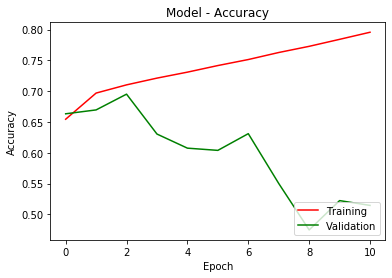

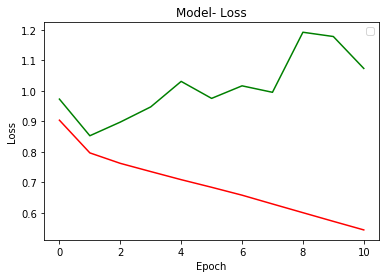

In [ ]:
evaluate_model(history, X_test, y_test, model)
y_pred = model.predict(X_test)